In [27]:
import lightgbm as lgb
import numpy as np
from binary_io import *

dataset = 'gist1m'
dataset = 'wikipedia'
dataset = 'imagenet'
M = 64
efc = 1000
efs = 1000
ck_ts = 2000
k = 10

# prefix = '/dk/lcj_rag/ANNS/test/'
data_prefix = '../../Bert-ANNS/data/'
prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}'

train_feature = fvecs_read(f'{data_prefix}{prefix}.train_feats_nn.fvecs')
train_label = ivecs_read(f'{data_prefix}{prefix}.train_label.ivecs')[:, 0]
test_feature = fvecs_read(f'{data_prefix}{prefix}.test_feats_nn.fvecs')
test_label = ivecs_read(f'{data_prefix}{prefix}.test_label.ivecs')[:, 0]

# train_feature = train_feature[:, -100:]
# test_feature = test_feature[:, -100:]
print(len(train_feature), len(train_label))
print(np.sum(test_label), np.sum(train_label))
print(len(train_feature[0]), train_feature[0][-101:])

500000 500000
321 24246
871 [-8.5430491e-01 -8.5071373e-01 -8.5056353e-01 -8.4821516e-01
 -8.4599900e-01 -8.4538597e-01 -8.4333915e-01 -8.4013999e-01
 -8.3822089e-01 -8.3793211e-01 -8.3558786e-01 -8.3511281e-01
 -8.3490831e-01 -8.3473575e-01 -8.3467233e-01 -8.3397418e-01
 -8.3343142e-01 -8.3315831e-01 -8.3297735e-01 -8.3287156e-01
 -8.3206666e-01 -8.3156210e-01 -8.3071870e-01 -8.2865310e-01
 -8.2659066e-01 -8.2615113e-01 -8.2499981e-01 -8.2492775e-01
 -8.2409054e-01 -8.2267576e-01 -8.2155603e-01 -8.2049274e-01
 -8.1946540e-01 -8.1784326e-01 -8.1727862e-01 -8.1635970e-01
 -8.1612062e-01 -8.1509721e-01 -8.1509721e-01 -8.1497860e-01
 -8.1490821e-01 -8.1400961e-01 -8.1354237e-01 -8.1332815e-01
 -8.1126249e-01 -8.1050062e-01 -8.1047726e-01 -8.1033278e-01
 -8.0997419e-01 -8.0947053e-01 -8.0879617e-01 -8.0855173e-01
 -8.0521303e-01 -8.0440605e-01 -8.0389684e-01 -8.0183649e-01
 -8.0156881e-01 -8.0104458e-01 -8.0022448e-01 -7.9988617e-01
 -7.9969132e-01 -7.9943085e-01 -7.9849017e-01 -7.9786634e

In [28]:
params = {
    'boosting_type': 'gbdt',    # 使用 GBDT 算法
    'objective': 'binary',  # 二分类任务
    'metric': 'binary_logloss',            # 使用 binary_logloss 作为评估指标
    'learning_rate': 0.05,       # 学习率
    'num_boost_round': 3000,     # 提升迭代的轮数
    'verbose': 1,               # 控制处理信息的详细程度
    'num_threads': 128           # 设置线程数
}

In [29]:
gbm = lgb.train(params, lgb.Dataset(train_feature, label=train_label))

/home/zhengweiguo/miniconda3/envs/lcj_bert/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 24246, number of negative: 475754
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222090
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 871
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048492 -> initscore=-2.976649
[LightGBM] [Info] Start training from score -2.976649


Area Under the Curve (AUC): 0.8243146417445484
0%->bruteforce | predict recall: 0.000000 | overall recall: 0.996790
2%->bruteforce | predict recall: 0.202492 | overall recall: 0.997440
4%->bruteforce | predict recall: 0.286604 | overall recall: 0.997710
6%->bruteforce | predict recall: 0.389408 | overall recall: 0.998040
8%->bruteforce | predict recall: 0.442368 | overall recall: 0.998210
10%->bruteforce | predict recall: 0.495327 | overall recall: 0.998380
12%->bruteforce | predict recall: 0.560748 | overall recall: 0.998590
14%->bruteforce | predict recall: 0.601246 | overall recall: 0.998720
16%->bruteforce | predict recall: 0.629283 | overall recall: 0.998810
18%->bruteforce | predict recall: 0.651090 | overall recall: 0.998880
20%->bruteforce | predict recall: 0.691589 | overall recall: 0.999010
22%->bruteforce | predict recall: 0.707165 | overall recall: 0.999060
24%->bruteforce | predict recall: 0.735202 | overall recall: 0.999150
26%->bruteforce | predict recall: 0.769470 | ove

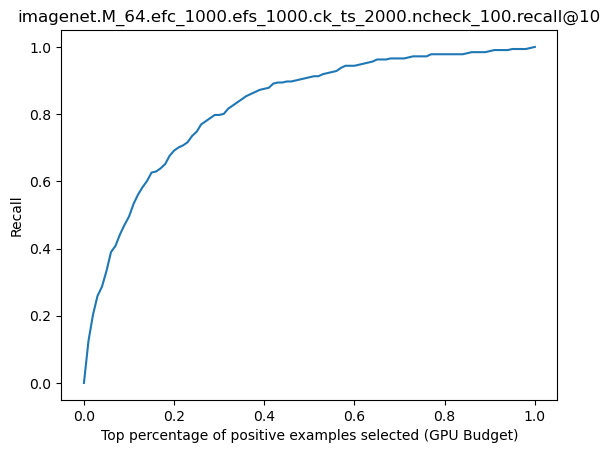

In [30]:
from sklearn.metrics import recall_score
import time
start = time.time()
label_pred = gbm.predict(test_feature)
end = time.time()

import numpy as np
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz

def recall_curve(test_label, label_pred):
    n = len(label_pred)
    recalls = []
    percentages = np.arange(0, 1.01, 0.01)  # 从0%到100%，步长为1%
    for p in percentages:
        threshold = np.percentile(label_pred, 100 * (1 - p))
        if p==0: threshold += 1
        new_label_pred = np.where(label_pred >= threshold, 1, 0)
        recall = recall_score(test_label, new_label_pred)
        recalls.append(recall)
    return percentages, recalls

percentages, recalls = recall_curve(test_label, label_pred)
auc = trapz(recalls, percentages)
print("Area Under the Curve (AUC):", auc)

total_true_label = np.sum(test_label)
step = 2
for p in range(0, 100 + step, step):
    fail = total_true_label * (1 - recalls[p])
    success = len(test_label) - fail
    overall_recall = (success * 1.000 + fail * 0.90) / len(test_label)
    print(f'{p}%->bruteforce | predict recall: {recalls[p]:4f} | overall recall: {overall_recall:6f}')

plt.plot(percentages, recalls)
plt.xlabel("Top percentage of positive examples selected (GPU Budget)")
plt.ylabel("Recall")

plt.title(f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}')
plt.savefig(f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.png')
plt.show()

# recall = recall_score(test_label, label_pred.round())
# print("Recall:", recall)